In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import fingerprinting
from collections import defaultdict
from scipy.ndimage.filters import maximum_filter
import mysql.connector
import os
import os.path
import pydub

%matplotlib inline

In [18]:
from scipy.ndimage.morphology import generate_binary_structure, iterate_structure, binary_erosion

In [20]:
neighborhood = iterate_structure(generate_binary_structure(2, 1), 20)

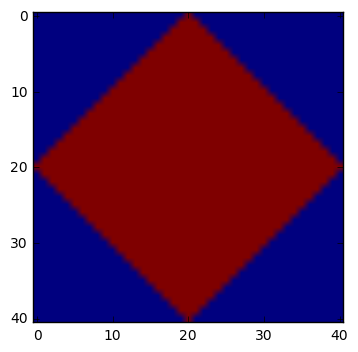

In [28]:
plt.imshow(neighborhood)

In [29]:
maximum_filter(a, footprint=neighborhood)

NameError: name 'maximum_filter' is not defined

In [ ]:
struct = generate_binary_structure(2, 1)
neighborhood = iterate_structure(struct, PEAK_NEIGHBORHOOD_SIZE)

# find local maxima using our fliter shape
local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
background = (arr2D == 0)
eroded_background = binary_erosion(background, structure=neighborhood,
                                   border_value=1)

# Boolean mask of arr2D with True at peaks
detected_peaks = local_max - eroded_background

In [4]:
freq, rec = wavfile.read('data/rec2_ultralight.wav')

/Users/dtochilkin/work/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [31]:
recording = rec[:,0]#song[1000000:2000000]

In [16]:
Audio(recording[:], rate = freq)

In [37]:
cnx = mysql.connector.connect(user='root', password='webster',
                              host='127.0.0.1',
                              database='fprints')

In [38]:
cursor = cnx.cursor()

In [8]:
add_fprint = ("INSERT IGNORE INTO fingerprints "
             "(hash, offset, song_id) VALUES (%s, %s, %s)")
add_song = ("INSERT INTO songnames "
           "(songname) VALUES (%s);")

In [9]:
select_fprint = ("SELECT offset, song_id FROM fingerprints WHERE hash = %s;")

In [10]:
select_song = ("SELECT songname FROM songnames WHERE song_id = %s")

In [11]:
select = ("SELECT fingerprints.offset, songnames.songname FROM "
          "fingerprints INNER JOIN songnames ON fingerprints.song_id = songnames.song_id "
          "WHERE fingerprints.hash = %s;")

In [37]:
cursor.execute(select, ('43573db1b1',))

In [62]:
for i in cursor:
    pass

In [12]:
def recognize(recording, cursor):
    rec_fprint_gen = fingerprinting.gen_fingerprint(recording)
    
    results = {}
    max_id = 0
    max_offset_count = 0
    for fprint in rec_fprint_gen:
        cursor.execute(select_fprint, (fprint[0][:10],))
        for (offset, song_id) in cursor:
            global_offset = int(fprint[1]) - offset
            if song_id in results.keys():
                if global_offset in results[song_id].keys():
                    results[song_id][global_offset] += 1
                    if results[song_id][global_offset] > max_offset_count:
                        max_id = song_id
                        max_offset_count = results[song_id][global_offset]
                else:
                    results[song_id][global_offset] = 1
            else:
                results[song_id] = {global_offset: 1}
    cursor.execute(select_song, (max_id,))
    return cursor.next(), max_offset_count

In [13]:
recording.min()

-32392

In [42]:
len(recording)

1310587

In [41]:
lengths = np.linspace(10, len(recording), 30)
bins = []
for l in lengths:
    bins.append(recognize(recording[:int(l)], cursor)[1])

StopIteration: 

In [17]:
recognize(recording, cursor)

/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)


(('03. David Bowie - Moonage Daydream',), 6)

In [80]:
recognize(recording[:500000], cursor)

(('06. Ocean Of Noise',), 123)

In [83]:
recognize(recording[:200000], cursor)

(('06. Ocean Of Noise',), 43)

In [29]:
cursor.close()
cnx.close()

In [15]:
arr2D = fingerprinting.get_specgram(song)

In [16]:
frequency_idx, time_idx = fingerprinting.get_2D_peaks(arr2D, True)

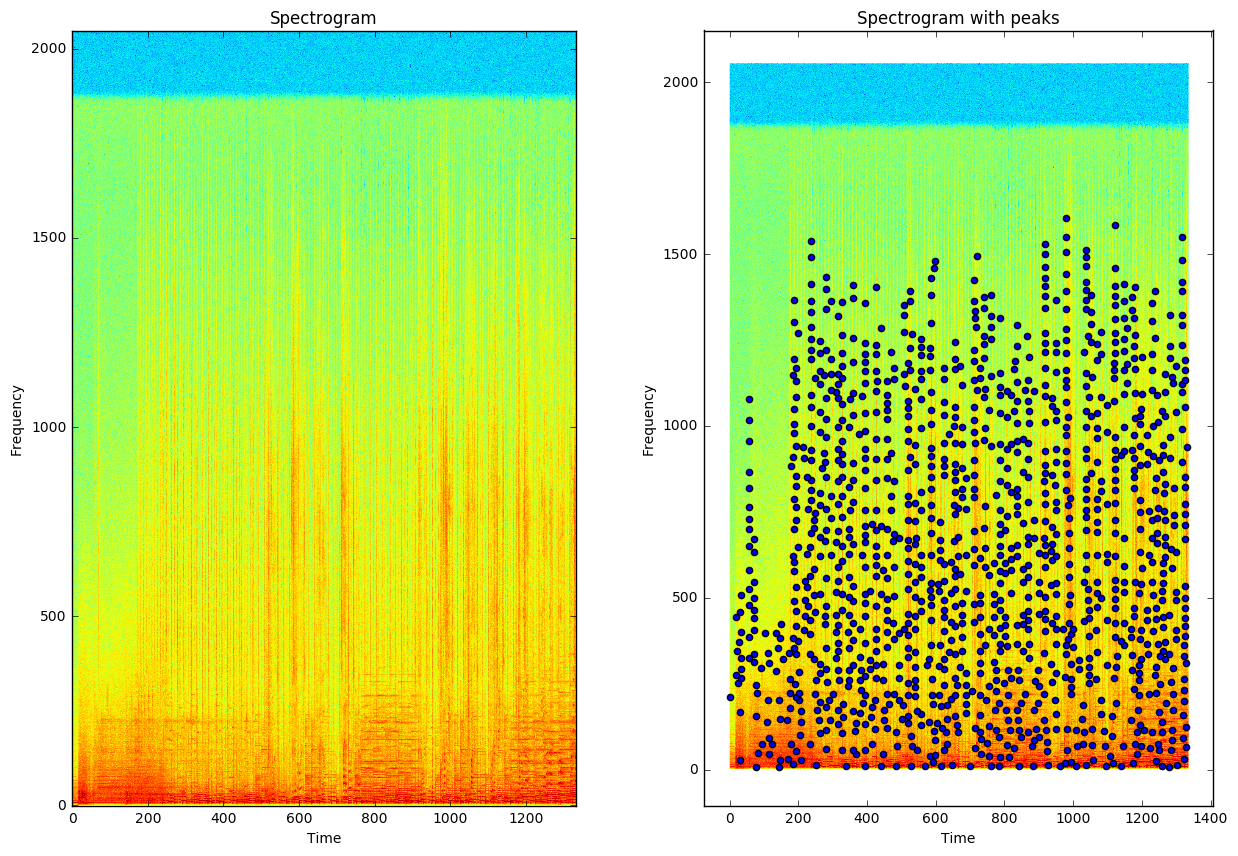

In [7]:
fingerprinting.plot_spectrograms(arr2D, time_idx, frequency_idx)

In [ ]:
for dirpath, dirnames, filenames in os.walk("data/"):
    for filename in [f for f in filenames if f.endswith(".mp3")]:
        full_path = os.path.join(dirpath, filename)
        sound = pydub.AudioSegment.from_mp3(full_path)
        sound = sound.set_channels(1)
        full_path_wav = full_path.replace('mp3', 'wav')
        sound.export(full_path_wav, format="wav")
        samp_freq, song = wavfile.read(full_path_wav)
        if samp_freq != 44100 or isinstance(song[0], list):
            continue
        try:
            hashes=fingerprinting.gen_fingerprint(song)
            cursor.execute(add_song, (filename[:-4],))
            song_id = cursor.lastrowid
            for h in hashes:
                cursor.execute(add_fprint, (h[0], int(h[1]), song_id,))
        except:
            print(full_path)
            break
        cnx.commit()
        os.remove(full_path)
#     break

/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in

data/David Bowie - DiscoGraphy (1966-2016) MP3 [320 kbps]-TX/Albums/2004.Black Tie White Noise/2004.Black Tie White Noise [Disc 2]/05.Miracle Goodnight [Make Believe Mix].mp3


/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in

data/David Bowie - DiscoGraphy (1966-2016) MP3 [320 kbps]-TX/Albums/2004.Black Tie White Noise/2004.Black Tie White Noise [Disc 1]/02.You've Been Around.mp3


/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)


data/David Bowie - DiscoGraphy (1966-2016) MP3 [320 kbps]-TX/Albums/1984.Tonight/06. David Bowie - Blue Jean.mp3


/Users/dtochilkin/Documents/Skoltech/image_processing/final_project/fingerprinting.py:27: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D)
